# BASELINE MODEL FOR RWIS RSC CLASSIFICATION

## Import libraries

In [1]:
# Libraries for file and data handling
%matplotlib inline
import os, sys
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import misc
import imageio
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import pickle
from random import shuffle, seed
seed(1)

## Data preparation

In [2]:
# Load the lists detailing the train and test files
with open('../input/rwis-data-split/split.pickle', 'rb') as handle:
    split_dic = pickle.load(handle)

In [3]:
# Obtain the lists
train = split_dic['train']
print('Images in train set:' + str(len(train)))
test = split_dic['test']
print('Images in test set:' + str(len(test)))

Images in train set:12600
Images in test set:1400


In [4]:
# Image dimensions
image_height = 299
image_width = 299
channels = 3
display_images = True

In [5]:
label_names = ['Bare pavement', 'Partial snow coverage', 'Full snow coverage']

In [6]:
# Function that prints the total number of images per category in the given set
def print_items(list_of_files):
    cat1 = 0
    cat2 = 0
    cat3 = 0
    for ifile in list_of_files:
        if 'C1' in ifile:
            cat1 += 1
        elif 'C2' in ifile:
            cat2 += 1
        elif 'C3' in ifile:
            cat3 += 1
    total = cat1+cat2+cat3
    print ('Total images: ' + str(total))
    print (label_names[0] + ' ' + str(cat1) + ' Approx. ' + str(int(cat1/total*100)) + '%')
    print (label_names[1] + ' ' + str(cat2) + ' Approx. ' + str(int(cat2/total*100)) + '%')
    print (label_names[2] + ' ' + str(cat3) + ' Approx. ' + str(int(cat3/total*100)) + '%')

In [7]:
print('- Summary of images in the train set -')
print_items(train)

- Summary of images in the train set -
Total images: 12600
Bare pavement 5691 Approx. 45%
Partial snow coverage 5114 Approx. 40%
Full snow coverage 1795 Approx. 14%


In [8]:
print('- Summary of images in the test set -')
print_items(test)

- Summary of images in the test set -
Total images: 1400
Bare pavement 648 Approx. 46%
Partial snow coverage 558 Approx. 39%
Full snow coverage 194 Approx. 13%


In [9]:
# Function that outputs the list of all files in the directory tree 
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            if '.jpg' in fullPath :
                allFiles.append(fullPath)    
    return allFiles

In [10]:
# Function to convert list of image filenames into numpy X and Y arrays
def getArrays(folder, list_of_files):
    
    # Number of images in the list
    numim = len(list_of_files)
    # Prepare array for the images
    images_array = np.ndarray(shape=(numim, image_height, image_width, channels), dtype=np.float16)
    # Prepare array for the labels
    labels_array = np.ndarray(shape = numim,dtype=np.uint8)
    # Set some counters
    idx_files = 0
    completion = 20
    
    # Loop over the filenames
    for ifile in list_of_files:
        fullpath = folder + ifile
        # From filename to numpy array
        img_arr = imageio.imread(fullpath)
        images_array[idx_files] = img_arr / 255.0
        # Obtain label from filename
        if '/C1/' in ifile:
            label = 0
        elif '/C2/' in ifile:
            label = 1
        elif '/C3/' in ifile:
            label = 2
        labels_array[idx_files] = label
        idx_files += 1
        
        # Print % of completion
        if (idx_files+1) % (numim//5) == 0:
            print('Completed ' + str(completion) + '%')
            completion += 20

    return images_array, labels_array

In [11]:
folder = "../input/rwis299/rwis299/rwis299"

In [12]:
# Import the corresponding images into numpy arrays 
X_train, y_train = getArrays(folder, train)
print('X_train shape is ' + str(X_train.shape))
print('y_train shape is ' + str(y_train.shape))

Completed 20%
Completed 40%
Completed 60%
Completed 80%
Completed 100%
X_train shape is (12600, 299, 299, 3)
y_train shape is (12600,)


In [13]:
# Import the corresponding images into numpy arrays 
X_test, y_test = getArrays(folder, test)
print('X_test shape is ' + str(X_test.shape))
print('y_test shape is ' + str(y_test.shape))

Completed 20%
Completed 40%
Completed 60%
Completed 80%
Completed 100%
X_test shape is (1400, 299, 299, 3)
y_test shape is (1400,)


/ER-14/C2/ER-Hwy401_Curry_Hill-p3-1515260700.jpg


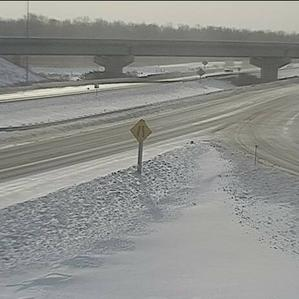

/ER-32/C3/ER-Hwy416_Rideau_River-p3-1515841200.jpg


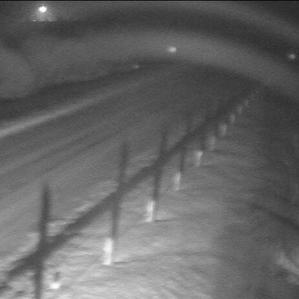

In [14]:
# Display some images from the train set
if display_images:    
    for i in range(0, 2):
        print(train[i])
        display(_Imgdis(filename=folder+train[i], width = image_width, height = image_height))

/CR-19/C2/CR-Hwy401_near_Newtonville_Rd-p1-1513948500.jpg


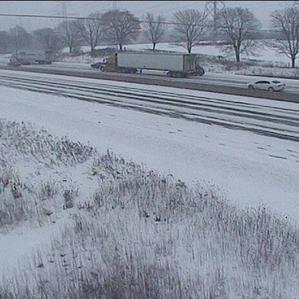

/NER-14/C1/NER-Hwy11_Marten_River-p1-1515527100.jpg


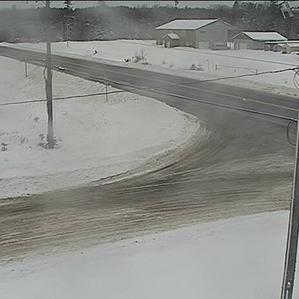

In [15]:
# Display some images from the test set
if display_images:
    for i in range(0, 2):
        print(test[i])
        display(_Imgdis(filename=folder+test[i], width = image_width, height = image_height))

## Model preparation

In [16]:
#Import Keras and TensorFlow libraries
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from time import time
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras import optimizers
from keras.utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [17]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [18]:
# Convert class vectors to binary class matrices.
num_classes = 3
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [19]:
print(y_train.shape)
print(y_test.shape)

(12600, 3)
(1400, 3)


## Defining the CNN architecture

In [20]:
# Create structure of Convolutional Neural Network
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(299, 299, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(19, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(23, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(28, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(33, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
view_model = True
if view_model:
    print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 19)      2755      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 19)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 23)        3956      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 23)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 28)        5824      
__________

## Model training

In [22]:
opt = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
batch_size = 32
epochs = 50

In [24]:
train_history = model.fit(x=X_train, y=y_train, batch_size=batch_size, 
                      epochs=epochs, verbose=1,
                      validation_split = 0.2,
                      shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 10080 samples, validate on 2520 samples
Epoch 1/50
10080/10080 [==============================] - 39s 4ms/step - loss: 1.0269 - acc: 0.4377 - val_loss: 0.9953 - val_acc: 0.4480
Epoch 2/50
10080/10080 [==============================] - 37s 4ms/step - loss: 0.9943 - acc: 0.4479 - val_loss: 0.9716 - val_acc: 0.4706
Epoch 3/50
10080/10080 [==============================] - 36s 4ms/step - loss: 0.9699 - acc: 0.4686 - val_loss: 0.9416 - val_acc: 0.5302
Epoch 4/50
10080/10080 [==============================] - 37s 4ms/step - loss: 0.9414 - acc: 0.5045 - val_loss: 0.8992 - val_acc: 0.5488
Epoch 5/50
10080/10080 [==============================] - 37s 4ms/step - loss: 0.9159 - acc: 0.5286 - val_loss: 0.8622 - val_acc: 0.5683
Epoch 6/50
10080/10080 [==============================] - 37s 4ms/step - loss: 0.8864 - acc: 0.5632 - val_loss: 0.8358 - val_acc: 0.5837
Epoch 7/50
10080/10080 [==============================] - 37s 4ms/step - loss: 0.

## Evaluate results

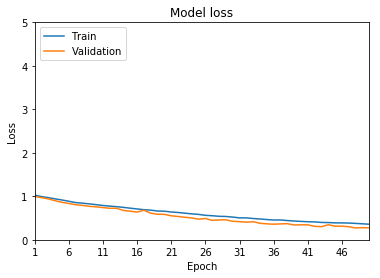

In [25]:
# Get the values from the training history dictionary
train_loss = train_history.history['loss'] 
val_loss = train_history.history['val_loss']

# Plot the resulting loss
plt.plot(range(1,1+len(train_loss)), train_loss)
plt.plot(range(1,1+len(val_loss)), val_loss)
plt.xticks(np.arange(1,1+len(train_loss),5))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
axes = plt.gca()
axes.set_xlim([1,len(train_loss)])
axes.set_ylim([0,5])
plt.show()

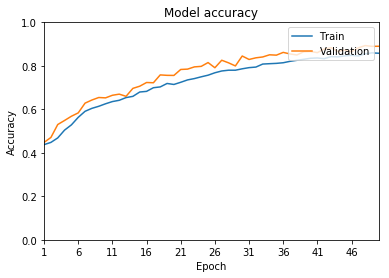

In [26]:
# Get the values from the training history dictionary
train_acc = train_history.history['acc'] 
val_acc = train_history.history['val_acc']

# Plot the resulting loss
plt.plot(range(1,1+len(train_acc)), train_acc)
plt.plot(range(1,1+len(val_acc)), val_acc)
plt.xticks(np.arange(1,1+len(train_acc),5))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
axes = plt.gca()
axes.set_xlim([1,len(train_acc)])
axes.set_ylim([0,1])
plt.show()

In [27]:
print("--Evaluation over the train and validation datasets--")
print("Final train loss: "+'{:6.4f}'.format(train_loss[-1]))   
print("Final validation loss: "+'{:6.4f}'.format(val_loss[-1]))   
print("Final train accuracy: "+'{:6.2f}'.format(train_acc[-1]*100)+'%')
print("Final validation accuracy: "+'{:6.2f}'.format(val_acc[-1]*100)+'%')

--Evaluation over the train and validation datasets--
Final train loss: 0.3580
Final validation loss: 0.2752
Final train accuracy:  85.79%
Final validation accuracy:  89.01%


In [28]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("--Evaluation over the test dataset--")
print("Loss: "+'{:6.4f}'.format(scores[0]))   
print("Accuracy: "+'{:6.2f}'.format(scores[1]*100)+'%')

--Evaluation over the test dataset--
Loss: 0.2860
Accuracy:  88.36%


## Save results

In [29]:
baseline_history_dic = {'train_loss':train_loss,
                    'test_loss':val_loss,
                     'train_acc':train_acc,
                      'test_acc':val_acc}

with open('baseline_history_ICF_12.pickle', 'wb') as handle:
    pickle.dump(baseline_history_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)